In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from os import listdir
import numpy as np
from scipy.stats import false_discovery_control
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
sns.set(style="ticks", font_scale=1.2)

# Global helper functions for plotting

In [2]:
def render_figure(path, folder="../../figures/anova", subfolder=None):
    if subfolder is not None:
        folder += f"/{subfolder}"
    outpath = f"{folder}/{path}.pdf"
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    print(f"Rendered figure to {outpath}")
    
def get_metric_group(iv):
    if "entropy" in iv:
        return "Uncertainty"
    elif "rank" in iv or "logprob_correct" in iv:
        return "Confidence"
    elif "logprobdiff" in iv:
        return "Relative confidence"
    elif "projDeltas" in iv or "boost" in iv:
        return "Boosting"
    elif iv == "baseline":
        return "Baseline"
    else:
        return iv
    
def get_quantity_type(iv):
    if "auc" in iv:
        return "AUC"
    elif "layer" in iv:
        return "MaxDeltaLayer"
    elif iv == "baseline":
        return iv
    else:
        return None
    
def get_model(file_prefix):
    splits = file_prefix.split("_")
    if splits[-1] == "filteredCorrect":
        return "_".join(splits[:-2])
    else:
        return "_".join(splits[:-1])
    
def get_dataset(file_prefix):
    splits = file_prefix.split("_")
    if splits[-1] == "filteredCorrect":
        return splits[-2]
    else:
        return splits[-1]
    
def get_dataset(file_prefix):
    splits = file_prefix.split("_")
    if splits[-1] == "filteredCorrect":
        return splits[-2]
    else:
        return splits[-1]
    
METRIC_GROUP_PAL = {
    "Uncertainty": "#FF7676FF",
    "Confidence": "#F9D662FF",
    "Relative confidence": "#7CAB7DFF",
    "Boosting": "#75B7D1FF"
}

TASK_DVS = {
    "capitals-recall": [
        "response_correct_strict", 
        "response_correct_gpt4", 
        "rt", 
        "time_stroke_after_last_empty_trial", 
        "n_keystrokes_len_norm",
        "n_backspace"
    ],
    "capitals-recognition": ["response_correct", "rt"],
    "animals": ["response_correct", "RT", "MAD", "AUC", "xpos_flips", "acc_max_time"],
    "syllogism": ["response_correct", "rt"],
    "vision": ["response_correct", "rt"]
}
DV_MAP = {
    "response_correct_strict": "Accuracy (strict)",
    "response_correct_gpt4": "Accuracy (lenient)",
    "rt": "Response time",
    "RT": "Response time",
    "n_keystrokes_len_norm": "# Presses / len(final answer)",
    "n_backspace": "# Backspace presses",
    "time_stroke_after_last_empty_trial": "Time of first press after last empty",
    "response_correct": "Accuracy",
    "MAD": "MAD of trajectory",
    "AUC": "AUC of trajectory",
    "xpos_flips": "X-position flips",
    "acc_max_time": "Time of max acceleration"
}

def get_sig_code(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    elif p < 0.1:
        return "."
    else:
        return ""
    
def get_pretty_metric(m):
    metric_map = {
        "auc_entropy": "Entropy AUC",
        "auc_rank_correct": "RRank AUC",
        "auc_logprob_correct": "Logprob AUC",
        "auc_logprobdiff_pos": "$\Delta$Logprob AUC+",
        "auc_logprobdiff_neg": "$\Delta$Logprob AUC-",
        "auc_boost_pos": "Boost AUC+",
        "auc_boost_neg": "Boost AUC-",
        "layer_biggest_change_entropy": "Entropy Layer",
        "layer_biggest_change_rank_correct": "RRank Layer",
        "layer_biggest_change_logprob_correct": "Logprob Layer",
        "layer_biggest_change_logprobdiff": "$\Delta$Logprob Layer",
        "layer_argmax_boost": "Boost Layer"
    }
    if m in metric_map:
        return metric_map[m]
    elif m.startswith("control") and m.replace("control_", "") in metric_map:
        return metric_map[m.replace("control_", "")] + " (Control)"
    else:
        return m
    
METRIC_ORDER = [
    "auc_entropy",
    "layer_biggest_change_entropy",
    "auc_rank_correct",
    "layer_biggest_change_rank_correct",
    "auc_logprob_correct",
    "layer_biggest_change_logprob_correct",
    "auc_logprobdiff_pos",
    "auc_logprobdiff_neg",
    "layer_biggest_change_logprobdiff",
    "auc_boost_pos",
    "auc_boost_neg",
    "layer_argmax_boost"
]
VISION_METRIC_ORDER = [
    "auc_entropy",
    "layer_biggest_change_entropy",
    "auc_rank_correct",
    "layer_biggest_change_rank_correct",
    "auc_logprob_correct",
    "layer_biggest_change_logprob_correct"
]

# Read results from ANOVAs

In [9]:
# Read ALL results (across all datasets and DVs) to perform false discovery correction.
def read_anova_results_single_task(task, result_dir="../anova_results"):
    dvs = TASK_DVS[task]
    files = [f for f in listdir(result_dir) if f.startswith(task)]
    dfs = []
    for f in files:
        if not any(f.endswith(f"{dv}.csv") for dv in dvs):
            print(f"Skipping {f}")
            continue
        df = pd.read_csv(f"{result_dir}/{f}")
        
        # Add dataset for vision tasks.
        if task == "vision":
            df["dataset"] = df.file_prefix.apply(get_dataset)
            df["model"] = df.file_prefix.apply(get_model)
        else:
            df["model"] = df.file_prefix
        
        # Add AIC and BIC metrics.
        df["AIC_diff_baseline"] = df[df.iv=="baseline"].squeeze()["AIC"] - df["AIC"] # HIGHER is better
        df["BIC_diff_baseline"] = df[df.iv=="baseline"].squeeze()["BIC"] - df["BIC"] # HIGHER is better

        # Add other relevant metadata.
        df["metric_group"] = df.iv.apply(get_metric_group)
        df["is_control"] = df.iv.apply(lambda x: x.startswith("control"))
        df["metric_quantity_type"] = df.iv.apply(get_quantity_type)
        dfs.append(df)
        
    if len(dfs) > 0:
        df = pd.concat(dfs)
        df["task"] = task
        return df
    else:
        return

def read_all_anova_results(result_dir="../anova_results", alpha=0.05):
    df = pd.concat([
        read_anova_results_single_task(task=task, result_dir=result_dir) 
        for task in ["capitals-recall", "capitals-recognition", "animals", "syllogism", "vision"]
    ])
    print("Total number of rows:", len(df))
    
    # False discovery control across ALL tests
    # Set aside baseline data.
    baseline = df[df["iv"] == "baseline"]
    
    # Get critical data with non-NA p-values.
    critical = df[
        (df["iv"] != "baseline") & \
        (~pd.isna(df["p.value"]))
    ]
    # Set FDR p values.
    print("Performing false discovery control")
    print("Total number of model comparison tests:", len(critical))
    p_fdr = false_discovery_control(critical["p.value"], method="by")
    critical["p_fdr"] = p_fdr
    critical["p_fdr_sig"] = critical["p_fdr"] < alpha
    
    # Recombine baseline and critical data.
    df = pd.concat([baseline, critical]).sort_values(by=["task", "dv", "model", "statistic"])
    
    return df
    
df = read_all_anova_results()
df.to_csv("../all_anova_results.csv", index=False)
print(df.model.unique())
df.head()

Total number of rows: 1133
Performing false discovery control
Total number of model comparison tests: 1010
['Llama-2-13b-hf' 'Llama-2-70b-hf' 'Llama-2-7b-hf' 'vit_base_patch16_224'
 'vit_small_patch16_224']


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_57539/1239968819.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  critical["p_fdr"] = p_fdr
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_57539/1239968819.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  critical["p_fdr_sig"] = critical["p_fdr"] < alpha


,term,npar,AIC,BIC,logLik,deviance,statistic,df,p.value,iv,...,p_fdr,model,AIC_diff_baseline,BIC_diff_baseline,metric_group,is_control,metric_quantity_type,task,dataset,p_fdr_sig
2,critical_fit,35,50576.136999,50770.648550,-25253.068499,50506.136999,0.140168,1.0,0.708114,layer_biggest_change_entropy,...,1.00000,Llama-2-13b-hf,-1.859832,-7.417305,Uncertainty,False,MaxDeltaLayer,animals,NaN,False
1,critical_fit,35,50575.923318,50770.434869,-25252.961659,50505.923318,0.353849,1.0,0.551943,auc_entropy,...,1.00000,Llama-2-13b-hf,-1.646151,-7.203624,Uncertainty,False,AUC,animals,NaN,False
11,critical_fit,35,50574.146563,50768.658115,-25252.073282,50504.146563,2.130603,1.0,0.144384,auc_boost_neg,...,1.00000,Llama-2-13b-hf,0.130603,-5.426870,Boosting,False,AUC,animals,NaN,False
10,critical_fit,35,50573.415566,50767.927118,-25251.707783,50503.415566,2.861600,1.0,0.090717,auc_boost_pos,...,1.00000,Llama-2-13b-hf,0.861600,-4.695873,Boosting,False,AUC,animals,NaN,False
9,critical_fit,35,50572.836822,50767.348374,-25251.418411,50502.836822,3.440344,1.0,0.063622,layer_biggest_change_logprobdiff,...,0.88103,Llama-2-13b-hf,1.440344,-4.117128,Relative confidence,False,MaxDeltaLayer,animals,NaN,False


# Capitals-recall, animals

capitals-recall BIC_diff_baseline Llama-2-70b-hf
response_correct_strict ['all_trials']
response_correct_gpt4 ['all_trials']
rt ['filteredCorrect']
time_stroke_after_last_empty_trial ['filteredCorrect']
n_keystrokes_len_norm ['filteredCorrect']
n_backspace ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recall_BIC_diff_baseline_no_control_Llama-2-70b-hf.pdf


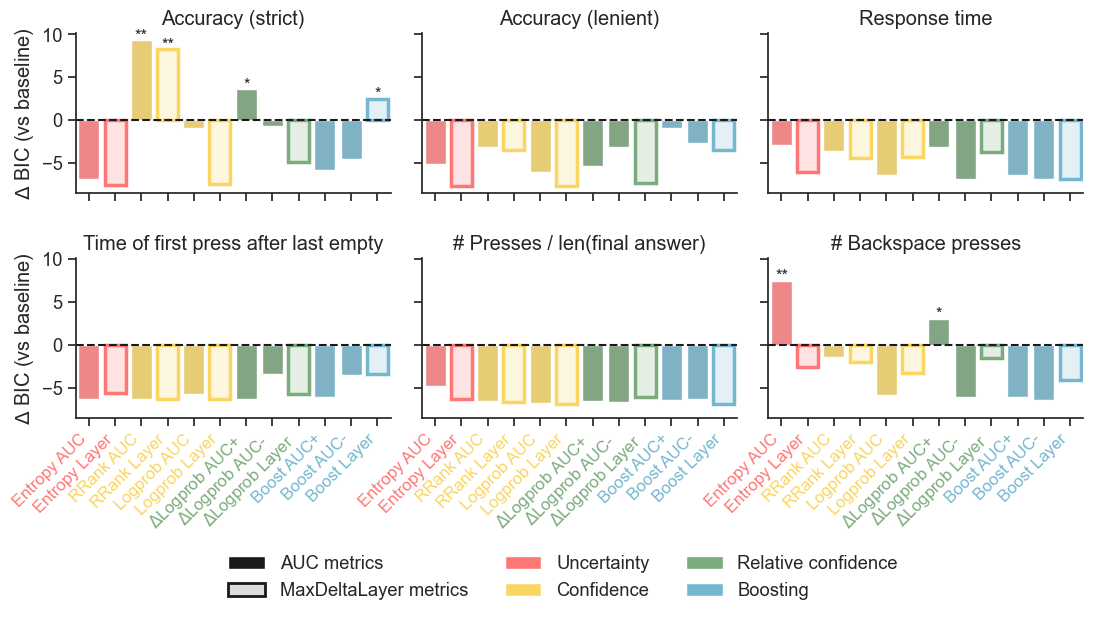

capitals-recall BIC_diff_baseline Llama-2-7b-hf
response_correct_strict ['all_trials']
response_correct_gpt4 ['all_trials']
rt ['filteredCorrect']
time_stroke_after_last_empty_trial ['filteredCorrect']
n_keystrokes_len_norm ['filteredCorrect']
n_backspace ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recall_BIC_diff_baseline_no_control_Llama-2-7b-hf.pdf


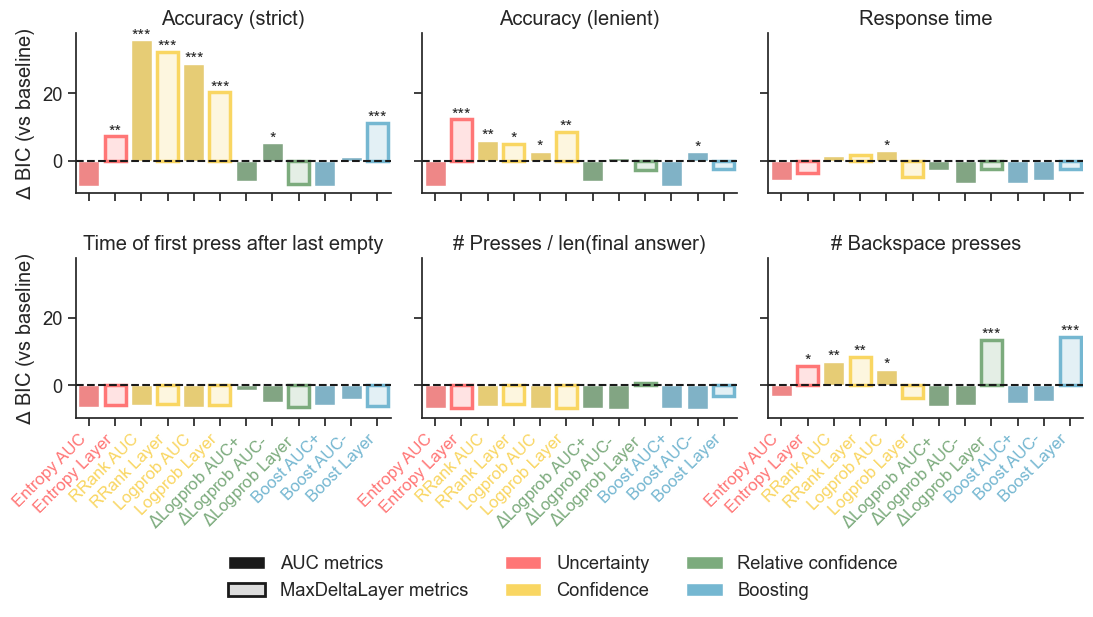

capitals-recall BIC_diff_baseline Llama-2-13b-hf
response_correct_strict ['all_trials']
response_correct_gpt4 ['all_trials']
rt ['filteredCorrect']
time_stroke_after_last_empty_trial ['filteredCorrect']
n_keystrokes_len_norm ['filteredCorrect']
n_backspace ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recall_BIC_diff_baseline_no_control_Llama-2-13b-hf.pdf


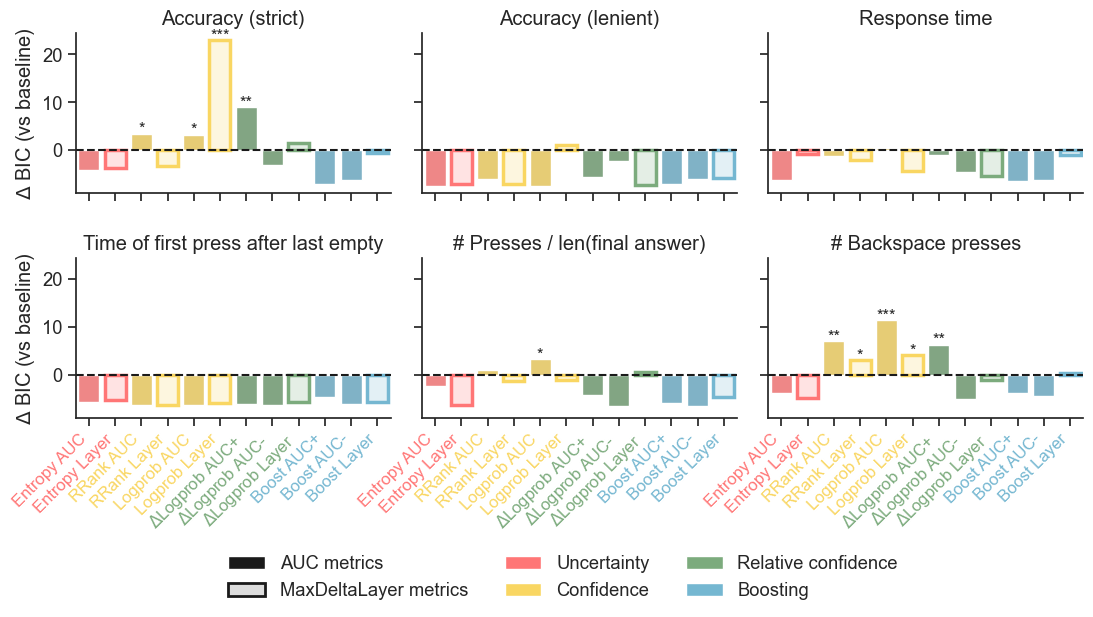

capitals-recall AIC_diff_baseline Llama-2-70b-hf
response_correct_strict ['all_trials']
response_correct_gpt4 ['all_trials']
rt ['filteredCorrect']
time_stroke_after_last_empty_trial ['filteredCorrect']
n_keystrokes_len_norm ['filteredCorrect']
n_backspace ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recall_AIC_diff_baseline_no_control_Llama-2-70b-hf.pdf


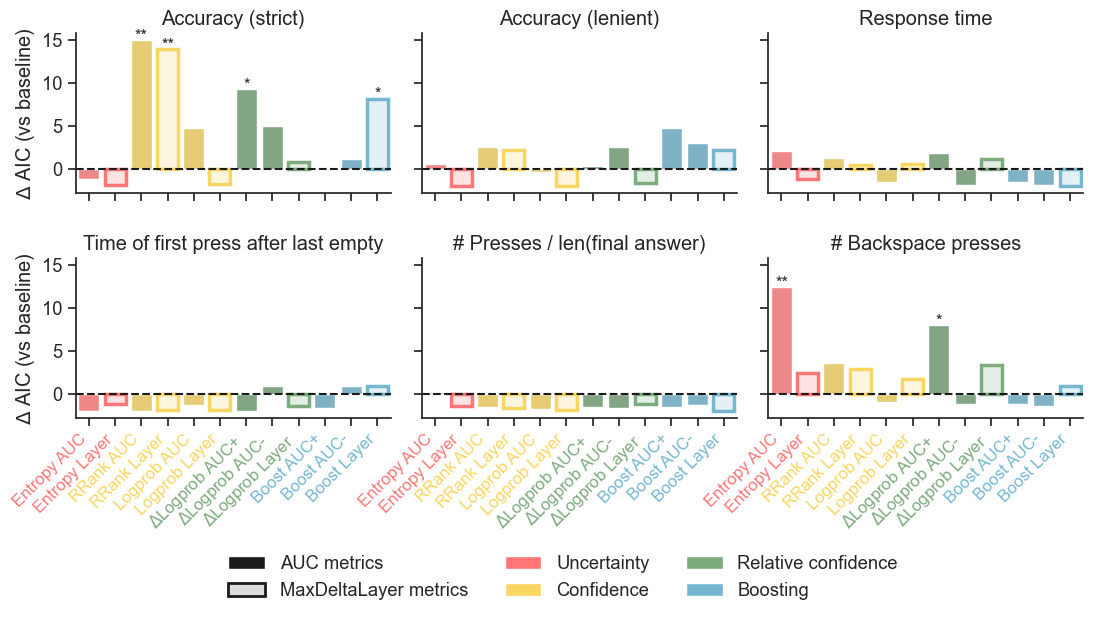

capitals-recall AIC_diff_baseline Llama-2-7b-hf
response_correct_strict ['all_trials']
response_correct_gpt4 ['all_trials']
rt ['filteredCorrect']
time_stroke_after_last_empty_trial ['filteredCorrect']
n_keystrokes_len_norm ['filteredCorrect']
n_backspace ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recall_AIC_diff_baseline_no_control_Llama-2-7b-hf.pdf


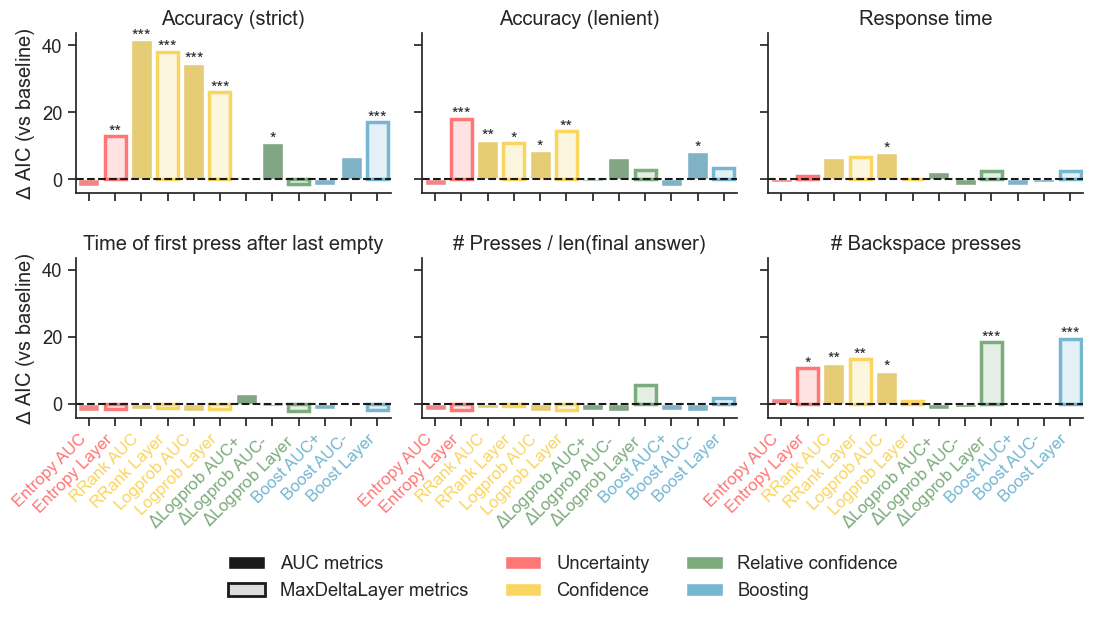

capitals-recall AIC_diff_baseline Llama-2-13b-hf
response_correct_strict ['all_trials']
response_correct_gpt4 ['all_trials']
rt ['filteredCorrect']
time_stroke_after_last_empty_trial ['filteredCorrect']
n_keystrokes_len_norm ['filteredCorrect']
n_backspace ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recall_AIC_diff_baseline_no_control_Llama-2-13b-hf.pdf


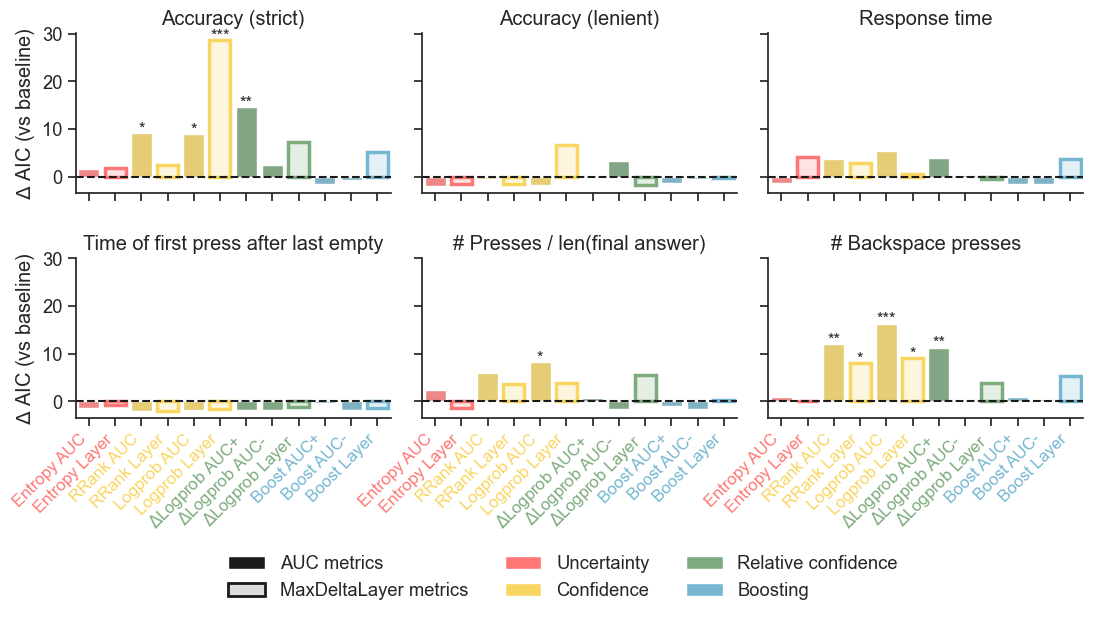

animals BIC_diff_baseline Llama-2-7b-hf
response_correct ['all_trials']
RT ['filteredCorrect']
MAD ['filteredCorrect']
AUC ['filteredCorrect']
xpos_flips ['filteredCorrect']
acc_max_time ['filteredCorrect']
Rendered figure to ../../figures/anova/animals_BIC_diff_baseline_no_control_Llama-2-7b-hf.pdf


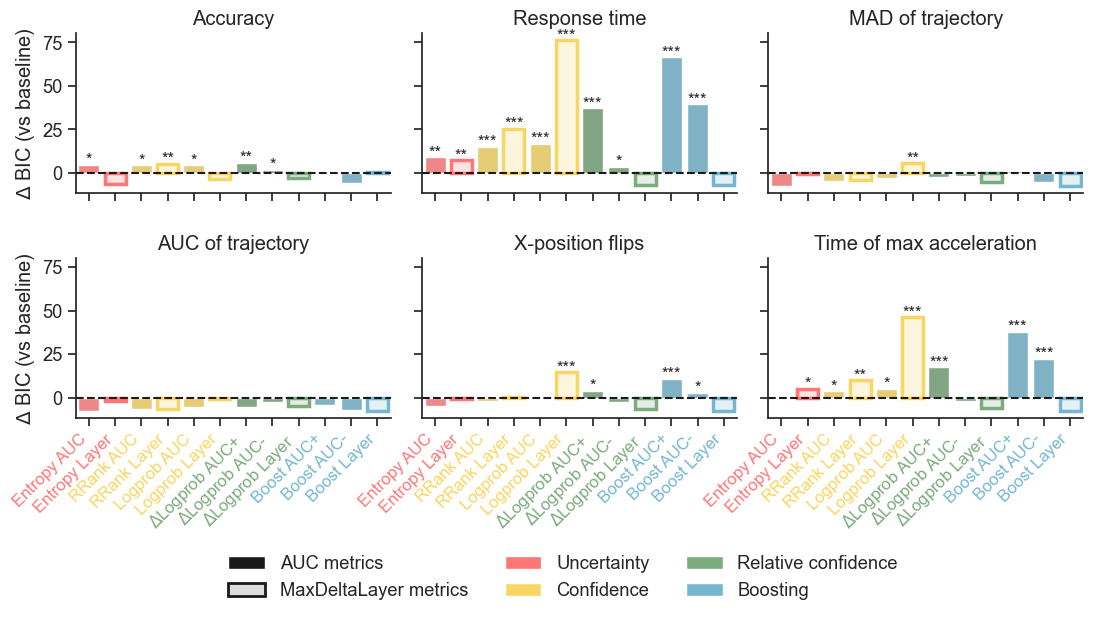

animals BIC_diff_baseline Llama-2-13b-hf
response_correct ['all_trials']
RT ['filteredCorrect']
MAD ['filteredCorrect']
AUC ['filteredCorrect']
xpos_flips ['filteredCorrect']
acc_max_time ['filteredCorrect']
Rendered figure to ../../figures/anova/animals_BIC_diff_baseline_no_control_Llama-2-13b-hf.pdf


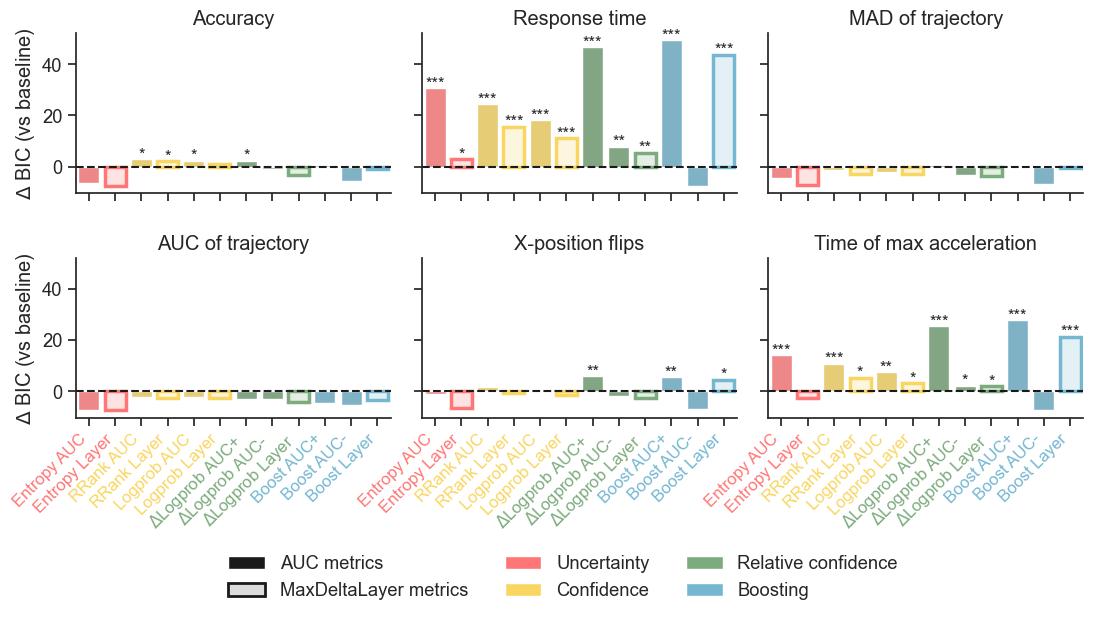

animals BIC_diff_baseline Llama-2-70b-hf
response_correct ['all_trials']
RT ['filteredCorrect']
MAD ['filteredCorrect']
AUC ['filteredCorrect']
xpos_flips ['filteredCorrect']
acc_max_time ['filteredCorrect']
Rendered figure to ../../figures/anova/animals_BIC_diff_baseline_no_control_Llama-2-70b-hf.pdf


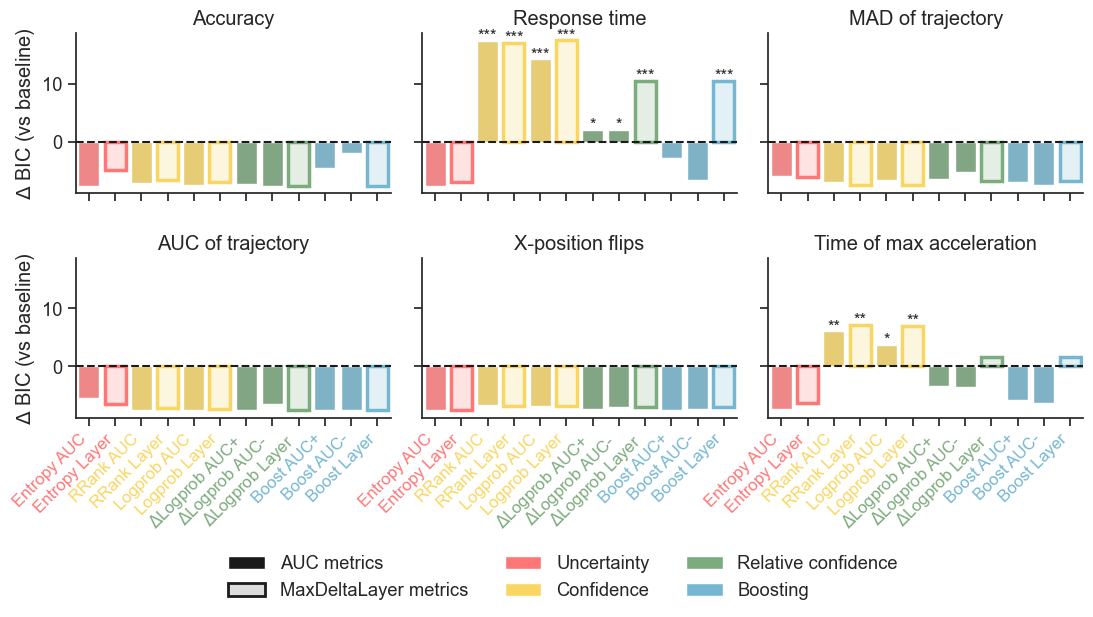

animals AIC_diff_baseline Llama-2-7b-hf
response_correct ['all_trials']
RT ['filteredCorrect']
MAD ['filteredCorrect']
AUC ['filteredCorrect']
xpos_flips ['filteredCorrect']
acc_max_time ['filteredCorrect']
Rendered figure to ../../figures/anova/animals_AIC_diff_baseline_no_control_Llama-2-7b-hf.pdf


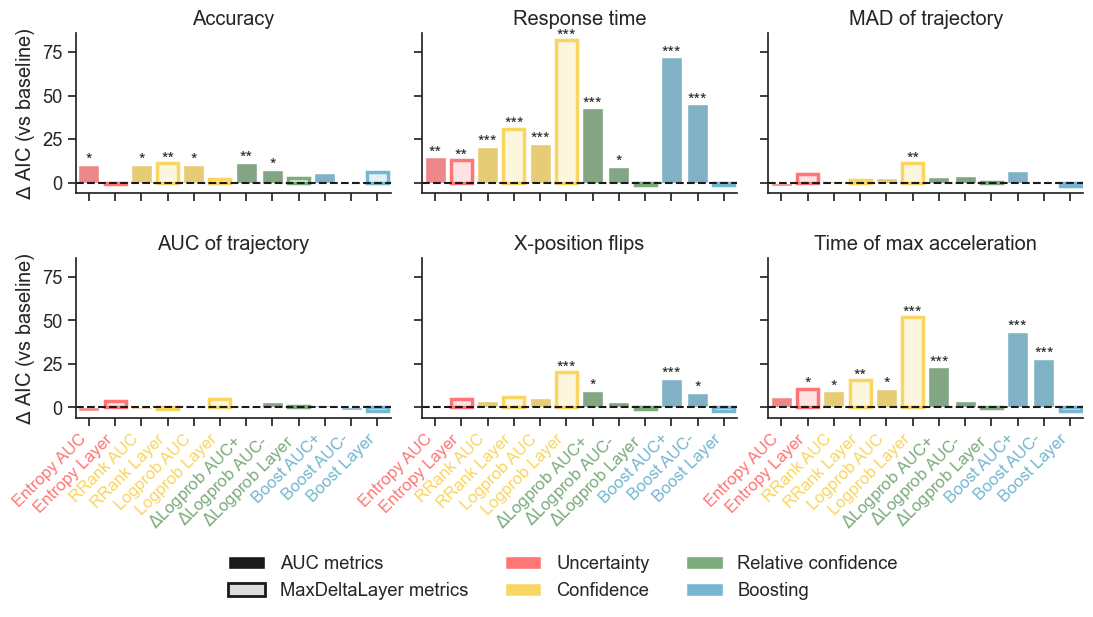

animals AIC_diff_baseline Llama-2-13b-hf
response_correct ['all_trials']
RT ['filteredCorrect']
MAD ['filteredCorrect']
AUC ['filteredCorrect']
xpos_flips ['filteredCorrect']
acc_max_time ['filteredCorrect']
Rendered figure to ../../figures/anova/animals_AIC_diff_baseline_no_control_Llama-2-13b-hf.pdf


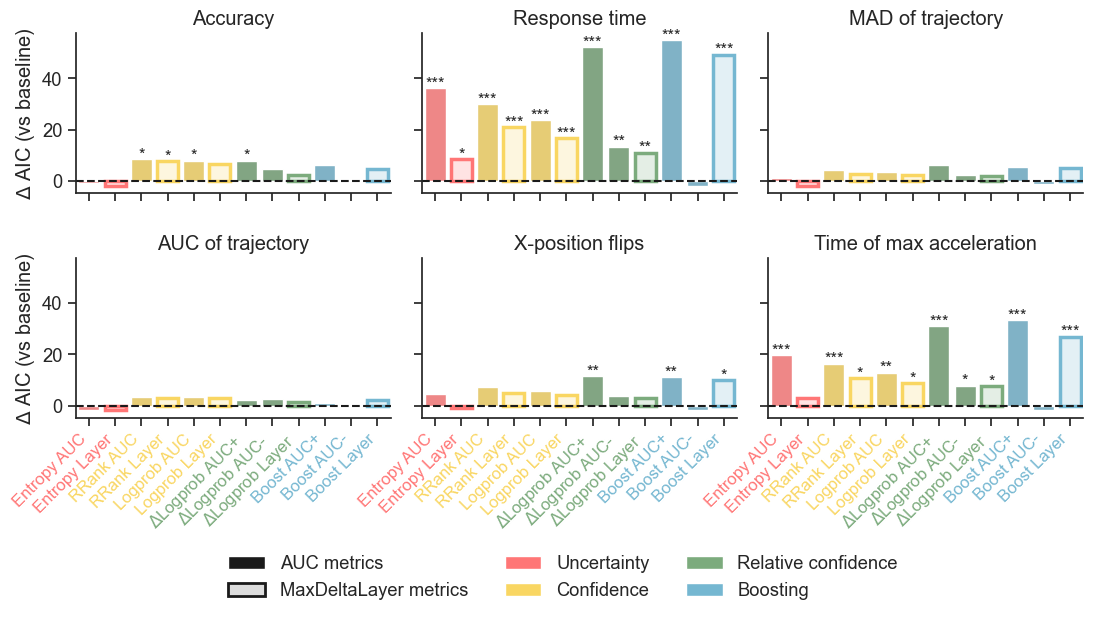

animals AIC_diff_baseline Llama-2-70b-hf
response_correct ['all_trials']
RT ['filteredCorrect']
MAD ['filteredCorrect']
AUC ['filteredCorrect']
xpos_flips ['filteredCorrect']
acc_max_time ['filteredCorrect']
Rendered figure to ../../figures/anova/animals_AIC_diff_baseline_no_control_Llama-2-70b-hf.pdf


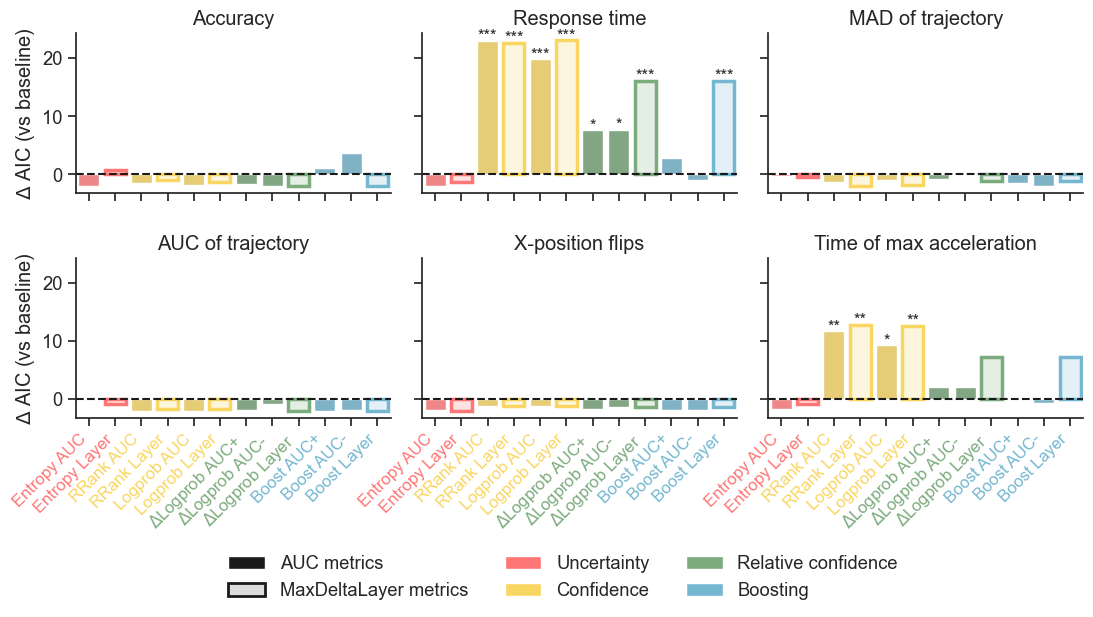

In [4]:
def plot_deltas_single_two_rows(df, task, metric="BIC_diff_baseline", render=False, suffix=""):
    dvs = TASK_DVS[task]
    assert len(dvs) == 6
    fig, axes = plt.subplots(
        nrows=2, 
        ncols=3,
        sharey=True, 
        sharex=True, 
        figsize=(13,5)
    )
    order = METRIC_ORDER
    
    for row in range(2):
        for col in range(3):
            ax = axes[row][col]
            flat_idx = row*3 + col
            dv = dvs[flat_idx]
            if DV_MAP[dv].startswith("Accuracy") or dv == "answer_with_valid":
                # if predicting accuracy, look at all trials
                rows = df[(df.dv==dv) & (df.data_subset=="all_trials")]
            else:
                # for other measures, look at correct subset
                rows = df[(df.dv==dv) & (df.data_subset=="filteredCorrect")]

            print(dv, rows.data_subset.unique())
            colors = [METRIC_GROUP_PAL[get_metric_group(o)] for o in order]
            ax = sns.barplot(
                data=rows,
                x="iv",
                y=metric,
                order=order,
                err_kws={"lw": 1},
                ax=ax,
                palette=colors,
                hue="iv",
                hue_order=order,
                legend=False
            )
            ax.axhline(0, linestyle="--", color="k")
            ax.set_xlabel("")
            if "aic" in metric.lower():
                ax.set_ylabel("$\Delta$ AIC (vs baseline)")
            else:
                ax.set_ylabel("$\Delta$ BIC (vs baseline)")
                
            ax.set_title(DV_MAP[dv])

            # Style the x-axis labels.
            ax.set_xticks(
                range(len(order)), 
                [get_pretty_metric(o) for o in order], 
                rotation=45, 
                ha="right", 
                size="small"
            )
            for i, lab in enumerate(ax.get_xticklabels()):
                lab.set_color(colors[i])

            # Annotate bars with significance results from ANOVA tests.
            rows = rows.set_index("iv")
            for i, o in enumerate(order):
                if rows.loc[o]["p_fdr_sig"]: # and rows.loc[o][metric] > 0:
                    p = rows.loc[o]["p_fdr"]
                    ax.text(i, max(0, rows.loc[o][metric]), get_sig_code(p), ha="center", size="small")

            # Customize colors/bar styles
            for i, container in enumerate(ax.containers):
                # container contains all bars for one level of the `hue` variable
                for j, child in enumerate(container.get_children()):
                    if "layer" in order[i]:
                        r,g,b = matplotlib.colors.to_rgb(colors[i])
                        child.set(color=(r,g,b,0.2), lw=2.5, ec=colors[i])
                    
        sns.despine()
        
    # Legend
    legend_elements = [
        Patch(facecolor='k', label='AUC metrics'),
        Patch(facecolor='gainsboro', edgecolor='k', lw=2, label='MaxDeltaLayer metrics'),
    ]
    legend_elements += [
        Patch(facecolor=METRIC_GROUP_PAL[group], label=group)
        for group in ["Uncertainty", "Confidence", "Relative confidence", "Boosting"]
    ]
    plt.figlegend(
        handles=legend_elements, 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.13),
        frameon=False,
        ncol=3
    )
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    
    if render:
        render_figure(f"{task}_{metric}{suffix}")
    plt.show()
        
for task in ["capitals-recall", "animals"]:
    for metric in ["BIC_diff_baseline", "AIC_diff_baseline"]:
        for model in df[df.task==task].model.unique():
            print(task, metric, model)
            plot_deltas_single_two_rows(
                df[(~df.is_control)&(df.task==task)&(df.model==model)], 
                task,
                metric=metric,
                render=True,
                suffix=f"_no_control_{model}"
            )
    print("="*80)

# Capitals-recognition

capitals-recognition BIC_diff_baseline Llama-2-13b-hf
response_correct ['all_trials']
rt ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recognition_BIC_diff_baseline_no_control_Llama-2-13b-hf.pdf


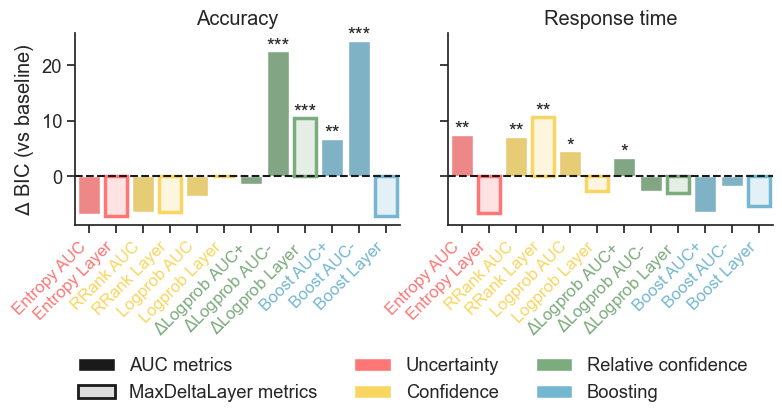

capitals-recognition BIC_diff_baseline Llama-2-7b-hf
response_correct ['all_trials']
rt ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recognition_BIC_diff_baseline_no_control_Llama-2-7b-hf.pdf


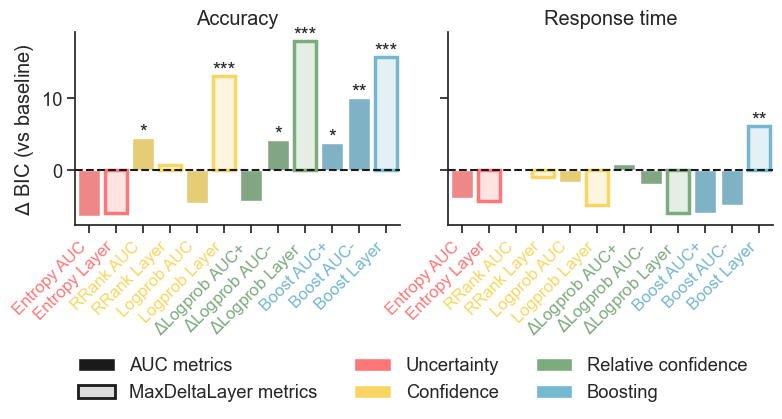

capitals-recognition BIC_diff_baseline Llama-2-70b-hf
response_correct ['all_trials']
rt ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recognition_BIC_diff_baseline_no_control_Llama-2-70b-hf.pdf


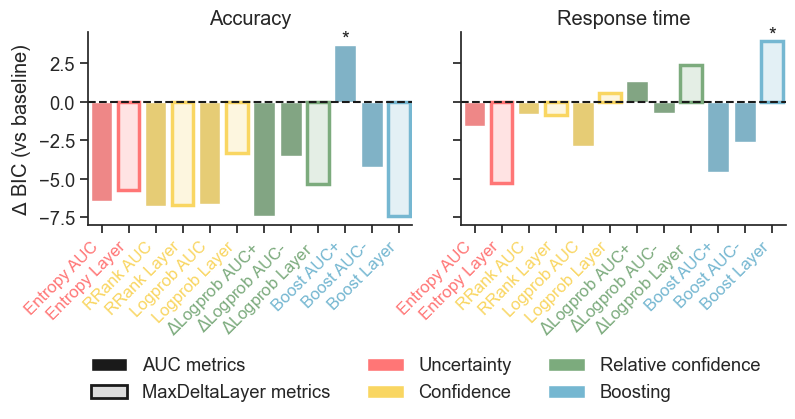

capitals-recognition AIC_diff_baseline Llama-2-13b-hf
response_correct ['all_trials']
rt ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recognition_AIC_diff_baseline_no_control_Llama-2-13b-hf.pdf


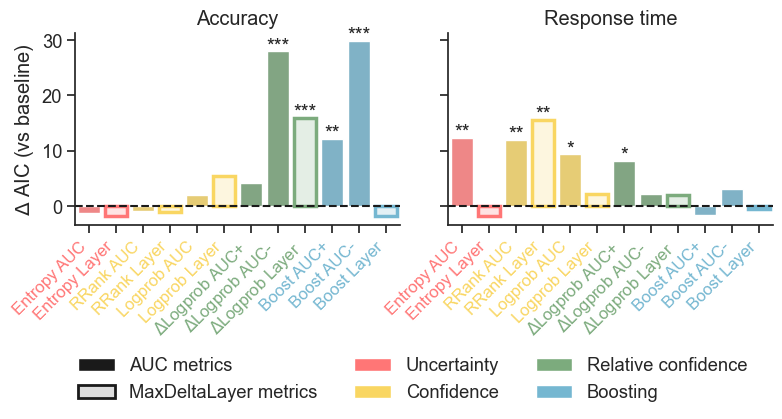

capitals-recognition AIC_diff_baseline Llama-2-7b-hf
response_correct ['all_trials']
rt ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recognition_AIC_diff_baseline_no_control_Llama-2-7b-hf.pdf


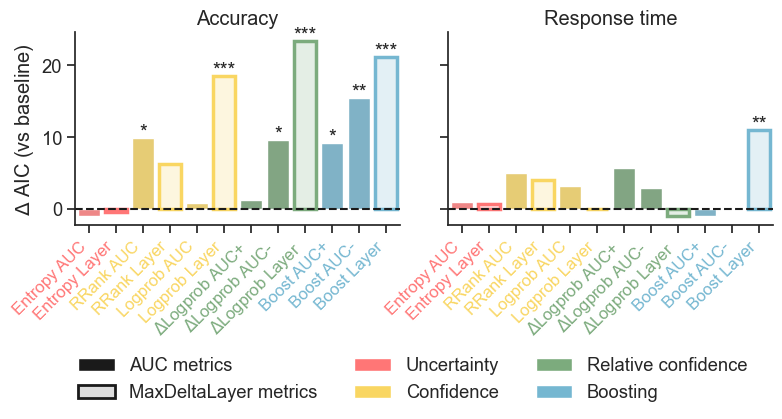

capitals-recognition AIC_diff_baseline Llama-2-70b-hf
response_correct ['all_trials']
rt ['filteredCorrect']
Rendered figure to ../../figures/anova/capitals-recognition_AIC_diff_baseline_no_control_Llama-2-70b-hf.pdf


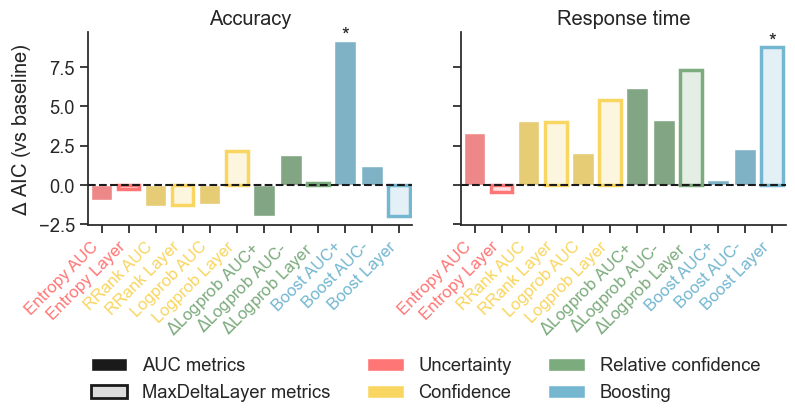

In [5]:
def plot_deltas_single(df, task, metric="BIC_diff_baseline", render=False, suffix=""):
    dvs = TASK_DVS[task]
    figsize = (9, 2.5)
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=len(dvs), 
        sharey=True, 
        sharex=True, 
        figsize=figsize
    )
    order = METRIC_ORDER
    
    for i, ax in enumerate(axes):
        dv = dvs[i]
        if DV_MAP[dv].startswith("Accuracy") or dv == "answer_with_valid":
            # if predicting accuracy, look at all trials
            if task == "syllogism":
                rows = df[(df.dv==dv) & (df.data_subset=="filteredRealistic")]
            else:
                rows = df[(df.dv==dv) & (df.data_subset=="all_trials")]
        else:
            # for other measures, look at correct subset
            if task == "syllogism":
                rows = df[(df.dv==dv) & (df.data_subset=="filteredRealisticCorrect")]
            else:
                rows = df[(df.dv==dv) & (df.data_subset=="filteredCorrect")]

        print(dv, rows.data_subset.unique())
        colors = [METRIC_GROUP_PAL[get_metric_group(o)] for o in order]
        ax = sns.barplot(
            data=rows,
            x="iv",
            y=metric,
            order=order,
            err_kws={"lw": 1},
            ax=ax,
            palette=colors,
            hue="iv",
            hue_order=order,
            legend=False
        )
        ax.axhline(0, linestyle="--", color="k")
        ax.set_xlabel("")
        if "aic" in metric.lower():
            ax.set_ylabel("$\Delta$ AIC (vs baseline)")
        else:
            ax.set_ylabel("$\Delta$ BIC (vs baseline)")
        ax.set_title(
            DV_MAP[dv].replace("\n", " "), size="medium"
        )
        
        # Style the x-axis labels.
        ax.set_xticks(
            range(len(order)), 
            [get_pretty_metric(o) for o in order], 
            rotation=45, 
            ha="right", 
            size="small"
        )
        for i, lab in enumerate(ax.get_xticklabels()):
            lab.set_color(colors[i])
            
        # Annotate bars with significance results from ANOVA tests.
        rows = rows.set_index("iv")
        for i, o in enumerate(order):
            if o not in rows.index:
                ax.text(i, 0.5, "NA", ha="center", size="xx-small", color="k", alpha=0.5)
            elif rows.loc[o]["p_fdr_sig"]: # and rows.loc[o][metric] > 0:
                p = rows.loc[o]["p_fdr"]
                ax.text(i, max(0, rows.loc[o][metric]), get_sig_code(p), ha="center")
        
        # Customize colors/bar styles
        for i, container in enumerate(ax.containers):
            # container contains all bars for one level of the `hue` variable
            for j, child in enumerate(container.get_children()):
                if "layer" in order[i]:
                    r,g,b = matplotlib.colors.to_rgb(colors[i])
                    child.set(color=(r,g,b,0.2), lw=2.5, ec=colors[i])
                    
        sns.despine()
        
    # Legend
    legend_elements = [
        Patch(facecolor='k', label='AUC metrics'),
        Patch(facecolor='gainsboro', edgecolor='k', lw=2, label='MaxDeltaLayer metrics'),
    ]
    legend_elements += [
        Patch(facecolor=METRIC_GROUP_PAL[group], label=group)
        for group in ["Uncertainty", "Confidence", "Relative confidence", "Boosting"]
    ]
    plt.figlegend(
        handles=legend_elements, 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.35),
        frameon=False,
        ncol=3
    )
    plt.subplots_adjust(wspace=0.15)
    
    if render:
        render_figure(f"{task}_{metric}{suffix}")
    plt.show()
        
for task in ["capitals-recognition"]:
    for metric in ["BIC_diff_baseline", "AIC_diff_baseline"]:
        for model in df[df.task==task].model.unique():
            print(task, metric, model)
            plot_deltas_single(
                df[(~df.is_control)&(df.task==task)&(df.model==model)],  
                task,
                metric=metric,
                render=True, 
                suffix=f"_no_control_{model}"
            )
    print("="*80)

# Syllogism

Llama-2-70b-hf
response_correct all_trials
rt filteredCorrect
rt filteredContentEffects
Rendered figure to ../../figures/anova/syllogism_BIC_diff_baseline_no_control_Llama-2-70b-hf.pdf


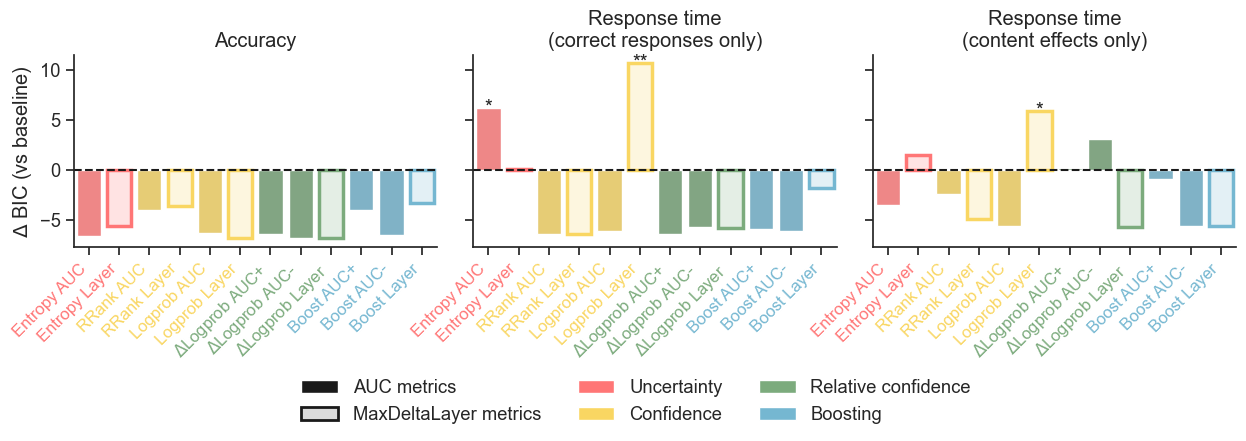

Llama-2-13b-hf
response_correct all_trials
rt filteredCorrect
rt filteredContentEffects
Rendered figure to ../../figures/anova/syllogism_BIC_diff_baseline_no_control_Llama-2-13b-hf.pdf


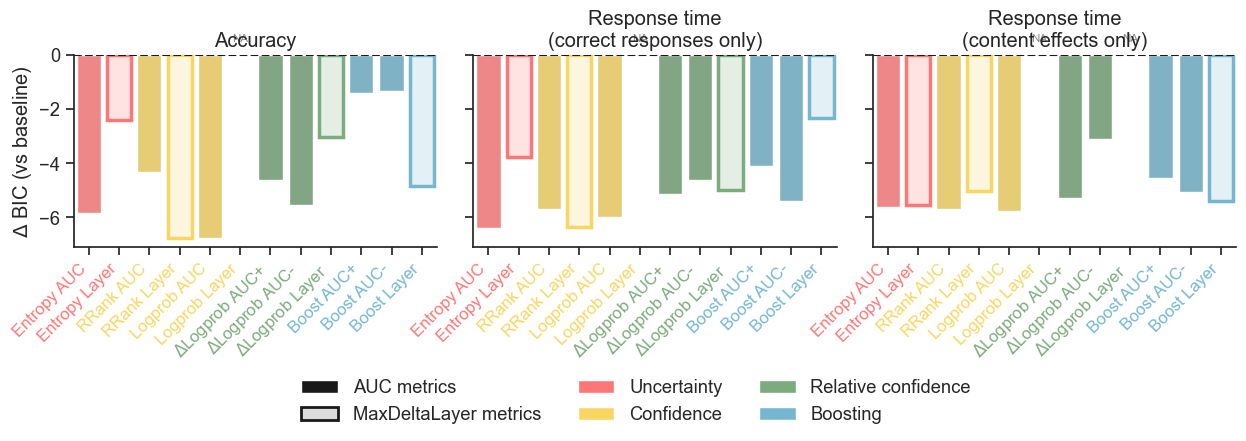

Llama-2-7b-hf
response_correct all_trials
rt filteredCorrect
rt filteredContentEffects
Rendered figure to ../../figures/anova/syllogism_BIC_diff_baseline_no_control_Llama-2-7b-hf.pdf


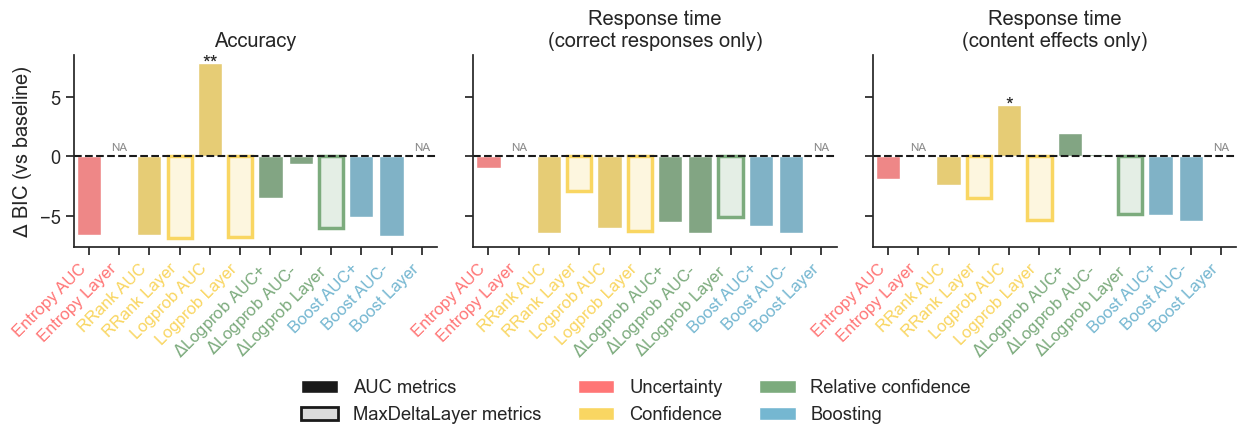

Llama-2-70b-hf
response_correct all_trials
rt filteredCorrect
rt filteredContentEffects
Rendered figure to ../../figures/anova/syllogism_AIC_diff_baseline_no_control_Llama-2-70b-hf.pdf


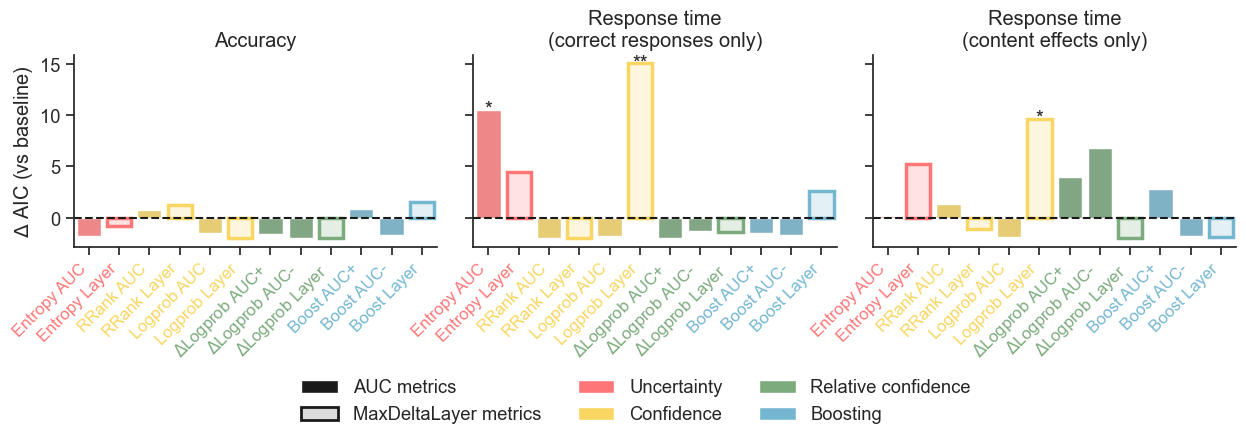

Llama-2-13b-hf
response_correct all_trials
rt filteredCorrect
rt filteredContentEffects
Rendered figure to ../../figures/anova/syllogism_AIC_diff_baseline_no_control_Llama-2-13b-hf.pdf


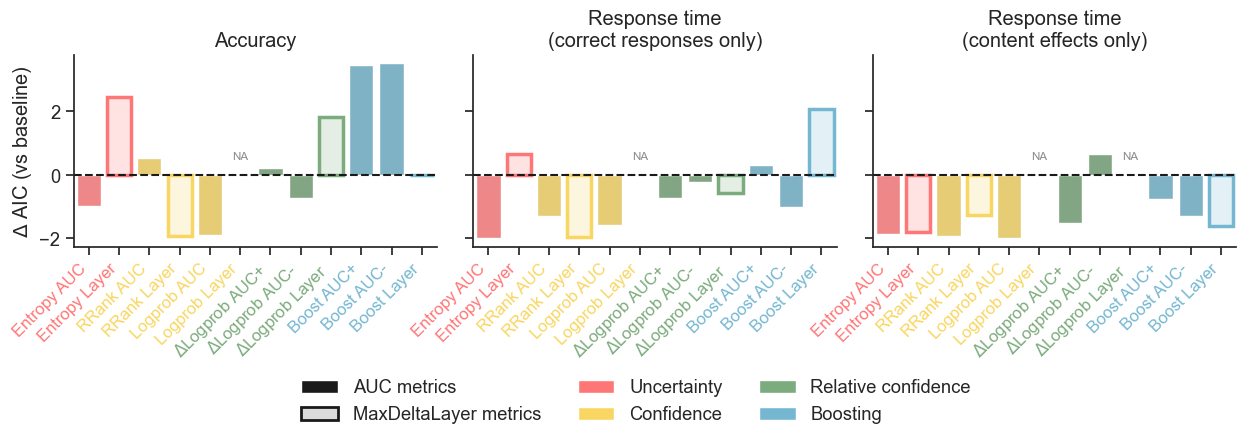

Llama-2-7b-hf
response_correct all_trials
rt filteredCorrect
rt filteredContentEffects
Rendered figure to ../../figures/anova/syllogism_AIC_diff_baseline_no_control_Llama-2-7b-hf.pdf


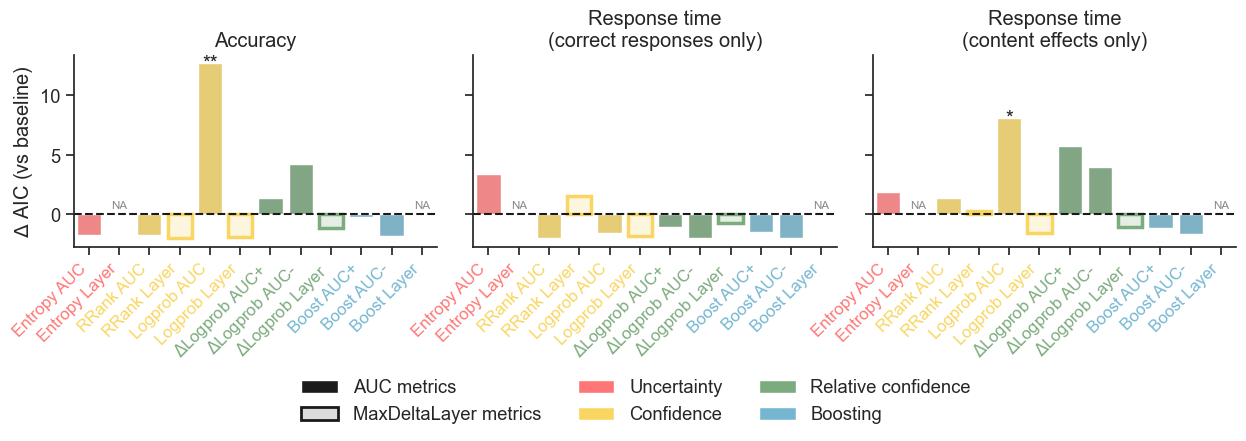

In [6]:
def plot_deltas_syllogism(df, task, metric="BIC_diff_baseline", render=False, suffix=""):
    conditions = [
        ("response_correct", "all_trials"),
        ("rt", "filteredCorrect"),
        ("rt", "filteredContentEffects"),
#         ("rt", "filteredRealistic")
    ]
    subset_label_map = {
        "filteredCorrect": "(correct responses only)",
        "filteredContentEffects": "(content effects only)",
        "filteredRealistic": "(realistic only)"
    }
    figsize = (15, 2.5)
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=len(conditions), 
        sharey=True, 
        sharex=True, 
        figsize=figsize
    )
    order = METRIC_ORDER
    
    for i, ax in enumerate(axes):
        dv, data_subset = conditions[i]
        print(dv, data_subset)
        rows = df[(df.dv==dv) & (df.data_subset==data_subset)]
        colors = [METRIC_GROUP_PAL[get_metric_group(o)] for o in order]
        ax = sns.barplot(
            data=rows,
            x="iv",
            y=metric,
            order=order,
            err_kws={"lw": 1},
            ax=ax,
            palette=colors,
            hue="iv",
            hue_order=order,
            legend=False
        )
        ax.axhline(0, linestyle="--", color="k")
        ax.set_xlabel("")
        if "aic" in metric.lower():
            ax.set_ylabel("$\Delta$ AIC (vs baseline)")
        else:
            ax.set_ylabel("$\Delta$ BIC (vs baseline)")
        if data_subset in subset_label_map:
            title = DV_MAP[dv] + "\n" + subset_label_map[data_subset]
        else:
            title = DV_MAP[dv]
        ax.set_title(title)
        
        # Style the x-axis labels.
        ax.set_xticks(
            range(len(order)), 
            [get_pretty_metric(o) for o in order], 
            rotation=45, 
            ha="right", 
            size="small"
        )
        for i, lab in enumerate(ax.get_xticklabels()):
            lab.set_color(colors[i])
            
        # Annotate bars with significance results from ANOVA tests.
        rows = rows.set_index("iv")
        for i, o in enumerate(order):
            if o not in rows.index:
                ax.text(i, 0.5, "NA", ha="center", size="xx-small", color="k", alpha=0.5)
            elif rows.loc[o]["p_fdr_sig"]: # and rows.loc[o][metric] > 0:
                p = rows.loc[o]["p_fdr"]
                ax.text(i, max(0.3, rows.loc[o][metric]-0.5), get_sig_code(p), ha="center")
        
        # Customize colors/bar styles
        for i, container in enumerate(ax.containers):
            # container contains all bars for one level of the `hue` variable
            for j, child in enumerate(container.get_children()):
                if "layer" in order[i]:
                    r,g,b = matplotlib.colors.to_rgb(colors[i])
                    child.set(color=(r,g,b,0.2), lw=2.5, ec=colors[i])
                    
        sns.despine()
        
    # Legend
    legend_elements = [
        Patch(facecolor='k', label='AUC metrics'),
        Patch(facecolor='gainsboro', edgecolor='k', lw=2, label='MaxDeltaLayer metrics'),
    ]
    legend_elements += [
        Patch(facecolor=METRIC_GROUP_PAL[group], label=group)
        for group in ["Uncertainty", "Confidence", "Relative confidence", "Boosting"]
    ]
    plt.figlegend(
        handles=legend_elements, 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.35),
        frameon=False,
        ncol=3
    )
    plt.subplots_adjust(wspace=0.1)
    
    if render:
        render_figure(f"{task}_{metric}{suffix}")
    plt.show()
        
for metric in ["BIC_diff_baseline", "AIC_diff_baseline"]:
    for model in df[df.task=="syllogism"].model.unique():
        print(model)
        plot_deltas_syllogism(
            df[(~df.is_control)&(df.task=="syllogism")&(df.model==model)],  
            "syllogism",
            metric=metric,
            render=True, 
            suffix=f"_no_control_{model}"
        )

# Vision

response_correct ['all_trials']
rt ['filteredCorrect']
Rendered figure to ../../figures/anova/vision_BIC_diff_baseline_grouped_no_control_vit_base_patch16_224.pdf


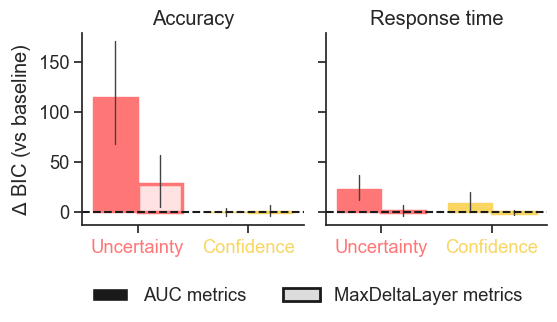

response_correct ['all_trials']
rt ['filteredCorrect']
Rendered figure to ../../figures/anova/vision_BIC_diff_baseline_grouped_no_control_vit_small_patch16_224.pdf


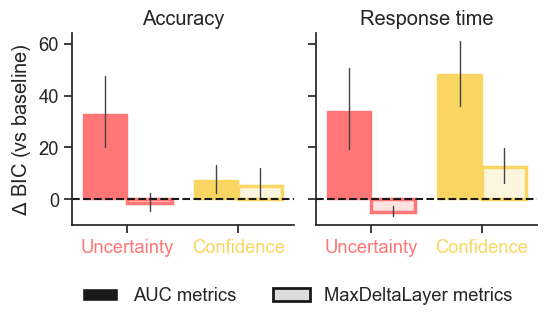

response_correct ['all_trials']
rt ['filteredCorrect']
Rendered figure to ../../figures/anova/vision_AIC_diff_baseline_grouped_no_control_vit_base_patch16_224.pdf


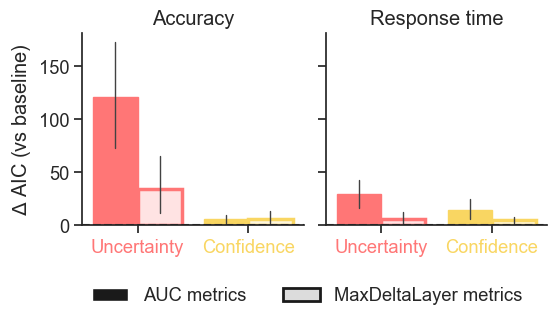

response_correct ['all_trials']
rt ['filteredCorrect']
Rendered figure to ../../figures/anova/vision_AIC_diff_baseline_grouped_no_control_vit_small_patch16_224.pdf


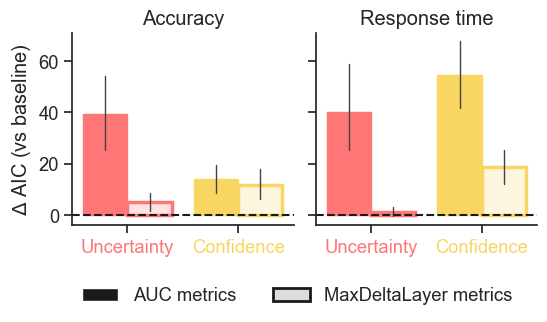

In [7]:
def plot_deltas_grouped(df, task, metric="BIC_diff_baseline", render=False, suffix=""):
    dvs = TASK_DVS[task]
    df = df[df.iv != "baseline"]

    # "COGNITIVE" METRIC GROUPING
    if task == "vision":
        order = ["Uncertainty", "Confidence"]
    else:
        order = ["Uncertainty", "Confidence", "Relative confidence", "Boosting"]
    colors = [METRIC_GROUP_PAL[o] for o in order]
    if len(dvs) == 2:
        figsize = (6, 2.5)
    elif task == "animals":
        figsize = (14, 2.5)
    else:
        figsize = (12, 2.5)
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=len(dvs), 
        sharey=True, 
        sharex=True, 
        figsize=figsize
    )
    for i, ax in enumerate(axes):
        dv = dvs[i]
        if DV_MAP[dv].startswith("Accuracy") or dv == "answer_with_valid":
            # if predicting accuracy, look at all trials
            if task == "syllogism":
                rows = df[(df.dv==dv) & (df.data_subset=="all_trials")]
            else:
                rows = df[(df.dv==dv) & (df.data_subset=="all_trials")]
        else:
            # for other measures, look at correct subset
            if task == "syllogism":
                rows = df[(df.dv==dv) & (df.data_subset=="filteredRealisticCorrect")]
            else:
                rows = df[(df.dv==dv) & (df.data_subset=="filteredCorrect")]

        print(dv, rows.data_subset.unique())
                
        ax = sns.barplot(
            data=rows,
            x="metric_group",
            y=metric,
            order=order,
            err_kws={"lw": 1},
            ax=ax,
            hue="metric_quantity_type",
            hue_order=["AUC", "MaxDeltaLayer"],
            legend=False
        )
        ax.axhline(0, linestyle="--", color="k")
        ax.set_xlabel("")
        if "aic" in metric.lower():
            ax.set_ylabel("$\Delta$ AIC (vs baseline)")
        else:
            ax.set_ylabel("$\Delta$ BIC (vs baseline)")
        ax.set_title(
            DV_MAP[dv].replace("\n", " "), size="medium"
        )
        ax.set_xticks(range(len(order)), order) #, rotation=35, ha="right")
        for i, lab in enumerate(ax.get_xticklabels()):
            lab.set_color(colors[i])
        
        # Customize colors/bar styles
        for i, container in enumerate(ax.containers):
            # container contains all bars for one level of the `hue` variable
            for j, child in enumerate(container.get_children()):
                if i == 0:
                    child.set(color=colors[j])
                else:
                    r,g,b = matplotlib.colors.to_rgb(colors[j])
                    child.set(color=(r,g,b,0.2), lw=2.5, ec=colors[j])
                    
        sns.despine()
        
    # Legend
    legend_elements = [
        Patch(facecolor='k', label='AUC metrics'),
        Patch(facecolor='gainsboro', edgecolor='k', lw=2, label='MaxDeltaLayer metrics'),
    ]
    plt.figlegend(
        handles=legend_elements, 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.07),
        frameon=False,
        ncol=2
    )
    plt.subplots_adjust(wspace=0.1)
    
    if render:
        render_figure(f"{task}_{metric}_grouped{suffix}")
    plt.show()

for metric in ["BIC_diff_baseline", "AIC_diff_baseline"]:
    for model in df[df.task=="vision"].model.unique():
        plot_deltas_grouped(
            df[(~df.is_control)&(df.task=="vision")&(df.model==model)], 
            "vision",
            render=True, 
            metric=metric,
            suffix=f"_no_control_{model}"
        )

Rendered figure to ../../figures/anova/vision_BIC_diff_baseline_by_dataset_no_control_vit_base_patch16_224.pdf


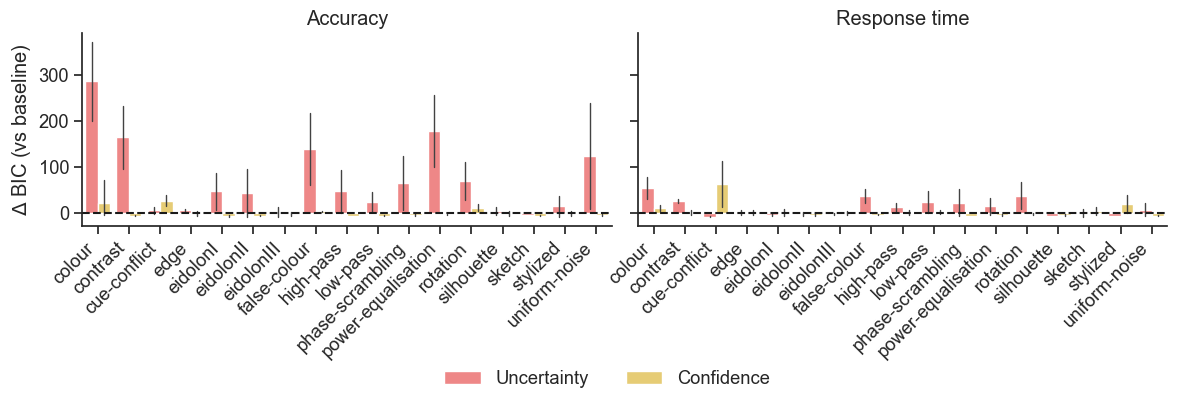

Rendered figure to ../../figures/anova/vision_BIC_diff_baseline_by_dataset_no_control_vit_small_patch16_224.pdf


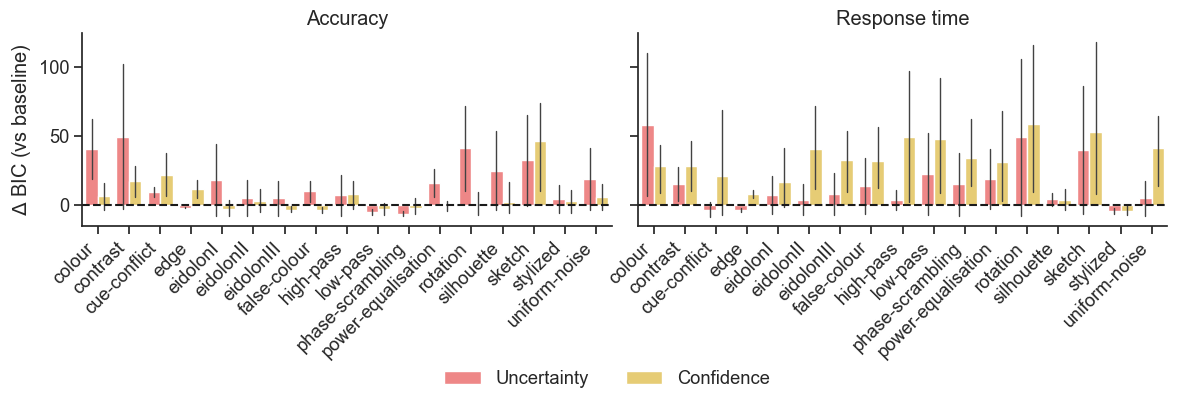

Rendered figure to ../../figures/anova/vision_AIC_diff_baseline_by_dataset_no_control_vit_base_patch16_224.pdf


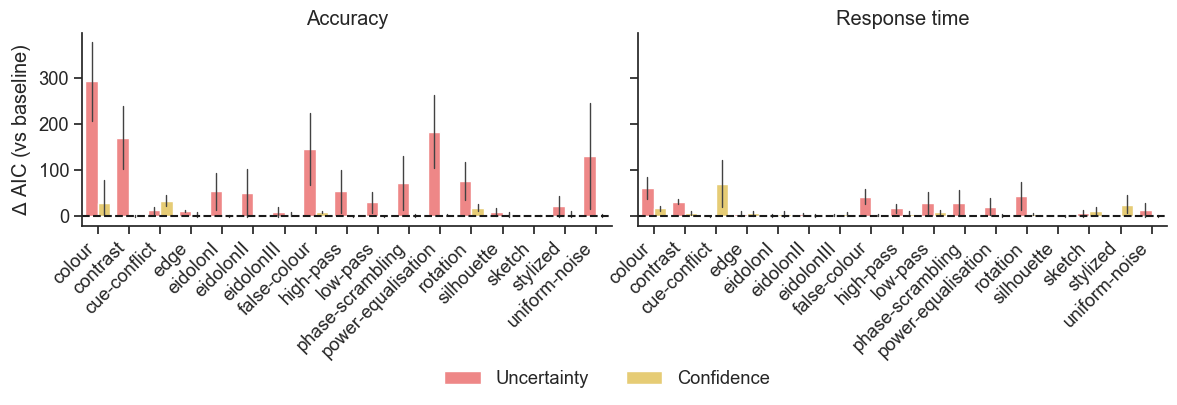

Rendered figure to ../../figures/anova/vision_AIC_diff_baseline_by_dataset_no_control_vit_small_patch16_224.pdf


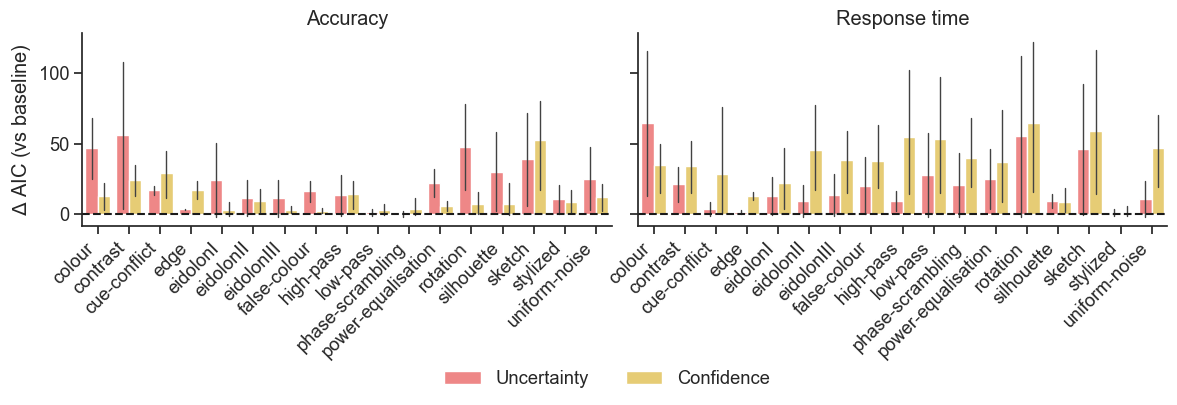

In [8]:
def plot_deltas_vision_datasets(df, task, render=False, suffix="", metric="BIC_diff_baseline"):
    VISION_DATASETS = [
        "colour",
        "contrast",
        "cue-conflict",
        "edge",
        "eidolonI",
        "eidolonII",
        "eidolonIII",
        "false-colour",
        "high-pass",
        "low-pass",
        "phase-scrambling",
        "power-equalisation",
        "rotation",
        "silhouette",
        "sketch",
        "stylized",
        "uniform-noise"
    ]
    
    df = df[df.iv!="baseline"]
    dvs = TASK_DVS[task]

    # "COGNITIVE" METRIC GROUPING
    hue_order = ["Uncertainty", "Confidence"]
    colors = [METRIC_GROUP_PAL[o] for o in hue_order]
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=len(dvs), 
        sharey=True, 
        sharex=True, 
        figsize=(14,2.5)
    )
    for i, ax in enumerate(axes):
        dv = dvs[i]
        
        if DV_MAP[dv] == "Accuracy":
            # if predicting accuracy, look at all trials
            rows = df[(df.dv==dv) & (df.data_subset=="all_trials")]
        else:
            # for other measures, look at correct subset
            rows = df[(df.dv==dv) & (df.data_subset=="filteredCorrect")]

        ax = sns.barplot(
            data=rows,
            x="dataset",
            y=metric,
            order=VISION_DATASETS,
            err_kws={"lw": 1},
            palette=colors,
            ax=ax,
            hue="metric_group",
            hue_order=hue_order,
        )
        ax.axhline(0, linestyle="--", color="k")
        ax.set_xlabel("")
        if "AIC" in metric:
            ax.set_ylabel("$\Delta$ AIC (vs baseline)")
        else:
            ax.set_ylabel("$\Delta$ BIC (vs baseline)")
        ax.set_title(DV_MAP[dv].replace("\n", " "))
        ax.set_xticks(range(len(VISION_DATASETS)), VISION_DATASETS, rotation=45, ha="right")
        ax.get_legend().remove()
        sns.despine()
        plt.subplots_adjust(wspace=0.05)

    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(
        handles[:2],
        labels[:2],
        ncol=2,
        frameon=False,
        loc="upper center", 
        bbox_to_anchor=(0.5, -0.4)
    )
    
    if render:
        render_figure(f"{task}_{metric}_by_dataset{suffix}")
    
    plt.show()

for metric in ["BIC_diff_baseline", "AIC_diff_baseline"]:
    for model in df[df.task=="vision"].model.unique():
        plot_deltas_vision_datasets(
            df[(~df.is_control)&(df.task=="vision")&(df.model==model)], 
            "vision",
            render=True, 
            suffix=f"_no_control_{model}",
            metric=metric
        )

In [19]:
df[df.task=="vision"].groupby(["model","dv","iv"])["p_fdr_sig"].value_counts(normalize=True)

model                  dv                iv                                    p_fdr_sig
vit_base_patch16_224   response_correct  auc_entropy                           True         0.941176
                                                                               False        0.058824
                                         auc_logprob_correct                   False        0.764706
                                                                               True         0.235294
                                         auc_rank_correct                      False        0.764706
                                                                               True         0.235294
                                         layer_biggest_change_entropy          True         0.529412
                                                                               False        0.470588
                                         layer_biggest_change_logprob_correct  False        0.705882
  